# RBC with Diﬀerent Intertemporal Elasticities of Substitution

In [1]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

### Menu:
    
Q1: Brief overview of the model see [Problem 1](#Problem_1).

Q2: Solve for the household’s ﬁrst-order condition for $K_{t+1}$ [Problem 2](#Problem_2).

Q3: Compute the steady state values of $A_{t}$, $K_{t}$, $C_{t}$, $Y_{t}$, $I_{t}$ [Problem 3](#Problem_3).

Q4: Compute the impulse responses for endogenous variables + Plot 4 computed impulse responses for each endogeneous variable [Problem 4](#Problem_4).

Q5: a) Compute and plot stochastic simulation of model’s endogenous variables. [Problem 5a](#Problem_5a).

Q5: b) Compute std of output, consumption, and investment in percent terms. [Problem 5b](#Problem_5b).

<a id='Problem_1'></a>

### 1. Brief overview of the model

Answer:

<a id='Problem_2'></a>
### 2. Solve for the household’s ﬁrst-order condition for $K_{t+1}$

#### The equilibrium conditions for model
\begin{align}
\frac{1}{C^{\gamma}_t} & = \beta E_t \left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1}+1-\delta }{C^{\gamma}_{t+1}}\right]\\
log A_{t+1} & = \rho \log A_t + \epsilon_{t+1}\\
K_{t+1} & = I_t + (1-\delta) K_t\\
Y_t & = A_t K_t^{\alpha}\\
Y_t & = C_t + I_t\\
\end{align}
where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. 

#### Assume the following values for the model's parameters
The objective is use `linearsolve` to simulate impulse responses to a TFP shock for $\gamma = 1,2,5,10$. Other parameter values are given in the table below:

| $$\beta$$ | $$\alpha$$| $$\delta$$ | $$\rho$$ | $$\sigma $$|
|-----------|-----------|------------|----------|------------|
| 0.99      | 0.35      | 0.025      | 0.75     |  0.006     |

#### Model Preparation
Write the model with all variables moved to the left-hand side of the equations and dropping the expecations operator $E_t$ and the exogenous shock $\epsilon_{t+1}$:
\begin{align}
0 & = \beta\left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1}+1-\delta }{C^{\gamma}_{t+1}}\right] - \frac{1}{C^{\gamma}_t}\\
0 & = \rho \log A_t - \log A_{t+1}\\
0 & = I_t + (1-\delta) K_t - K_{t+1}\\
0 & = A_t K_t^{\alpha} - Y_t\\
0 & = C_t + I_t - Y_t\\
\end{align}

<a id='Problem_3'></a>
### 3. Compute the steady state values of $A_{t}$, $K_{t}$, $C_{t}$, $Y_{t}$, $I_{t}$

#### Initialization, Approximation, and Solution
Initialize the model in `linearsolve` and then approximate and solve it.

In [2]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series.
parameters = pd.Series(dtype=float)
parameters['beta'] = 0.99
parameters['alpha'] = 0.35
parameters['delta'] = 0.025
parameters['rho'] = 0.75
parameters['sigma'] = 0.006

In [3]:
# Create variable called 'var_names' that stores the variable names in a list with exogenous state variables ordered first, endogenous state variables ordered second, and control variables ordered last.
var_names = ['a','k','c','y','i']

# Create variable called 'shock_names' that stores an exogenous shock name for each exogenous state variable.
shock_names = ['e_a']

In [4]:
# Define a function that evaluates the equilibrium conditions of the model solved for zero.
def equilibrium_equations(variables_forward,variables_current,parameters):
    #print(variables_forward)
    
    # Parameters.
    p = parameters
    
    # Current variables.
    cur = variables_current
    
    # Forward variables.
    fwd = variables_forward
    
    #1 # Euler equation
    mpk = p.alpha*fwd.a*fwd.k**(p.alpha-1)
    euler_equation = p.beta*(mpk+1-p.delta)/(fwd.c**p.gamma) - 1/(cur.c**p.gamma)

    #2 Exogenous tfp evolution
    tfp_process = p.rho*np.log(cur.a) - np.log(fwd.a)
    
    #3 Capital evolution
    capital_evolution = cur.i + (1 - p.delta)*cur.k - fwd.k
    
    #4 Production function
    production_function = cur.a * cur.k**p.alpha - cur.y
    
    #5 Market clearing
    market_clearing = cur.c + cur.i - cur.y   

    # Stack equilibrium conditions into a numpy array
    return np.array([
        euler_equation,
        tfp_process,
        capital_evolution,
        production_function,
        market_clearing
        ])

In [5]:
# Initialize the model into a variable named 'rbc_model'.
rbc_model = ls.model(equations = equilibrium_equations,
                     n_states=2,
                     n_exo_states=1,
                     var_names=var_names,
                     shock_names=shock_names,
                     parameters=parameters)

In [6]:
# Compute the steady state numerically using .compute_ss() method of nk_model
parameters['gamma'] = 1
guess = [1, 1, 1, 1, 1]
rbc_model.compute_ss(guess)

# Print the computed steady state
print(rbc_model.ss)

a     1.000000
k    34.398226
c     2.589794
y     3.449750
i     0.859956
dtype: float64


<a id='Problem_4'></a>
### 4. Compute the impulse responses for endogenous variables + Plot 4 computed impulse responses for each endogeneous variable

#### Simulation and Plotting Impulse Responses
Compute a 41 period impulse response of the model's variables to a 0.01 unit shock to TFP in period 5. Plot 4 computed impulse responses for each endogeneous variable

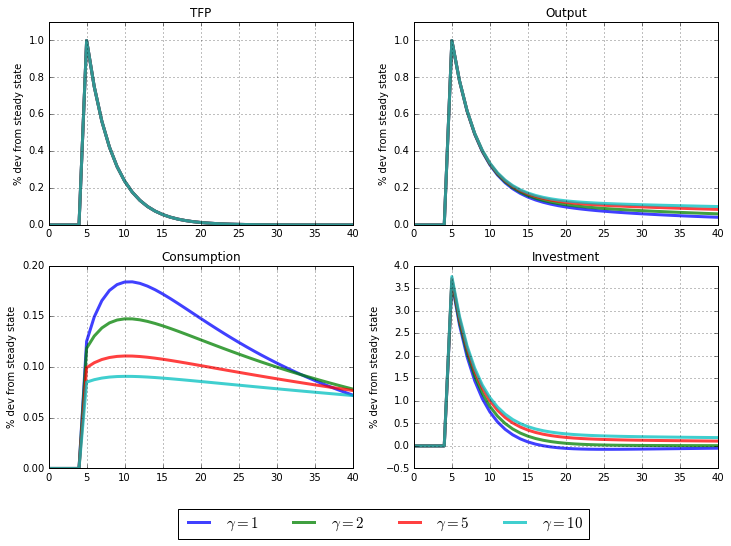

In [7]:
# Create a figure
fig = plt.figure(figsize=(12,8))

# Create four axis variables
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# Create an axis equal to the size of the figure. 
ax0 = fig.add_subplot(1,1,1)
# Turn off the axis so that the underlying axes are visible.
ax0.set_frame_on(False)
# Hide the x-axis. 
ax0.get_xaxis().set_visible(False)
# Hide the y-axis. 
ax0.get_yaxis().set_visible(False)

# Create variable called 'rho_values' that stores the desired values of gamma
gamma_values = [1, 2, 5, 10]

# Iterate over the elements of gamma_values
for gamma in gamma_values:
    
    # Update the value of gamma in rbc_model.parameters
    rbc_model.parameters['gamma'] = gamma
    
    # Approximate the model and solve
    rbc_model.approximate_and_solve()
    
    # Compute the impulse responses to a 0.01 unit shock to TFP
    rbc_model.impulse(T=41, t0=5, shocks=[0.01])
    
    # Add plots of TFP, output, labor, and consumption to ax1, ax2, ax3, and ax4
    ax1.plot(rbc_model.irs['e_a']['a']*100,lw=3,alpha=0.75)
    ax2.plot(rbc_model.irs['e_a']['y']*100,lw=3,alpha=0.75)
    ax3.plot(rbc_model.irs['e_a']['c']*100,lw=3,alpha=0.75)
    ax4.plot(rbc_model.irs['e_a']['i']*100,lw=3,alpha=0.75)
    
    # Plot the point 0,0 on ax0 with the same line properties used for the other plotted lines and provide a label
    ax0.plot(0, 0, lw=3, alpha=0.75, label='$\\gamma='+str(gamma)+'$')

# Set title
ax1.set_title('TFP')
ax2.set_title('Output') 
ax3.set_title('Consumption')
ax4.set_title('Investment')

# Set ylabel
ax1.set_ylabel('% dev from steady state')
ax2.set_ylabel('% dev from steady state')
ax3.set_ylabel('% dev from steady state')
ax4.set_ylabel('% dev from steady state')

# Add grid to the axis 
ax1.grid() 
ax2.grid()
ax3.grid()
ax4.grid()

# Set y-axis limits
ax1.set_ylim([0,1.1])
ax2.set_ylim([0,1.1])
ax3.set_ylim([0,0.2])
ax4.set_ylim([-0.5,4])

# Add legend below the figure. 
legend = ax0.legend(loc='upper center',bbox_to_anchor=(0.5,-0.075), ncol=4,fontsize=15)

#### Compute the impulse responses for endogenous variables

In [8]:
# Print the first 10 rows of the computed impulse responses to the TFP shock
print(rbc_model.irs['e_a'].head(10))

    e_a         a         k         c         y         i
0  0.00  0.000000  0.000000  0.000000  0.000000  0.000000
1  0.00  0.000000  0.000000  0.000000  0.000000  0.000000
2  0.00  0.000000  0.000000  0.000000  0.000000  0.000000
3  0.00  0.000000  0.000000  0.000000  0.000000  0.000000
4  0.00  0.000000  0.000000  0.000000  0.000000  0.000000
5  0.01  0.010000  0.000000  0.000851  0.010000  0.037553
6  0.00  0.007500  0.000939  0.000875  0.007829  0.028770
7  0.00  0.005625  0.001635  0.000891  0.006197  0.022177
8  0.00  0.004219  0.002148  0.000901  0.004971  0.017228
9  0.00  0.003164  0.002525  0.000906  0.004048  0.013510


<a id='Problem_5a'></a>

### Q5 (a) Compute and plot stochastic simulation of model’s endogenous variables

<a id='Problem_5b'></a>

### Q5 (b) Compute std of output, consumption, and investment in percent terms.

#### Stochastic Simulation

Compute a 401 period stochastic simulation of the model. Set $\gamma=1, 20$, and set the seed for the simulation to 2022.

##### For ${\gamma = 1}$

In [9]:
# Set the value of gamma in rbc_model.parameters to 1
rbc_model.parameters['gamma'] = 1

# Approximate the model and solve
rbc_model.approximate_and_solve()

# Compute the stochastic simulation using the .stoch_sim() method of rbc_model
rbc_model.stoch_sim(T=401, cov_mat=[parameters['sigma']**2], seed=2022)

Text(0, 0.5, '% dev from steady state')

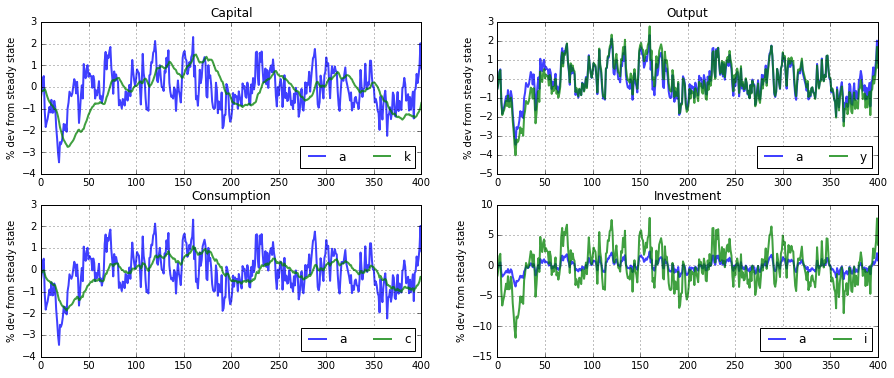

In [10]:
# Create figure.
fig = plt.figure(figsize=(15,6))

# Create four axis variables
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# Create an axis equal to the size of the figure. 
ax0 = fig.add_subplot(1,1,1)
# Turn off the axis so that the underlying axes are visible.
ax0.set_frame_on(False)
# Hide the x-axis and y-axis
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

# Plot endogenous variables.
(rbc_model.simulated[['a','k']]*100).plot(lw=2, alpha=0.75, grid=True, ax=ax1).legend(loc='lower right',ncol=2)
(rbc_model.simulated[['a','y']]*100).plot(lw=2, alpha=0.75, grid=True, ax=ax2).legend(loc='lower right',ncol=2)
(rbc_model.simulated[['a','c']]*100).plot(lw=2, alpha=0.75, grid=True, ax=ax3).legend(loc='lower right',ncol=2)
(rbc_model.simulated[['a','i']]*100).plot(lw=2, alpha=0.75, grid=True, ax=ax4).legend(loc='lower right',ncol=2)

# Set title
ax1.set_title('Capital')
ax2.set_title('Output') 
ax3.set_title('Consumption')
ax4.set_title('Investment')

# Set ylabel
ax1.set_ylabel('% dev from steady state')
ax2.set_ylabel('% dev from steady state')
ax3.set_ylabel('% dev from steady state')
ax4.set_ylabel('% dev from steady state')

In [11]:
# Print the standard deviations (times 100) of output, consumption, and investment in the simulated data
print(rbc_model.simulated[['y','c','i']].std()*100)

# Print the correlations of output, consumption, and investment in the simulated data
print(rbc_model.simulated[['y','c','i']].corr())

y    1.068278
c    0.603292
i    3.202199
dtype: float64
          y         c         i
y  1.000000  0.732847  0.922484
c  0.732847  1.000000  0.413383
i  0.922484  0.413383  1.000000


#### For ${\gamma = 20}$

In [12]:
# Set the value of gamma in rbc_model.parameters to 20
rbc_model.parameters['gamma'] = 20

# Approximate the model and solve
rbc_model.approximate_and_solve()

# Compute the stochastic simulation using the .stoch_sim() method of rbc_model
rbc_model.stoch_sim(T=401, cov_mat=[parameters['sigma']**2], seed=2022)

Text(0, 0.5, '% dev from steady state')

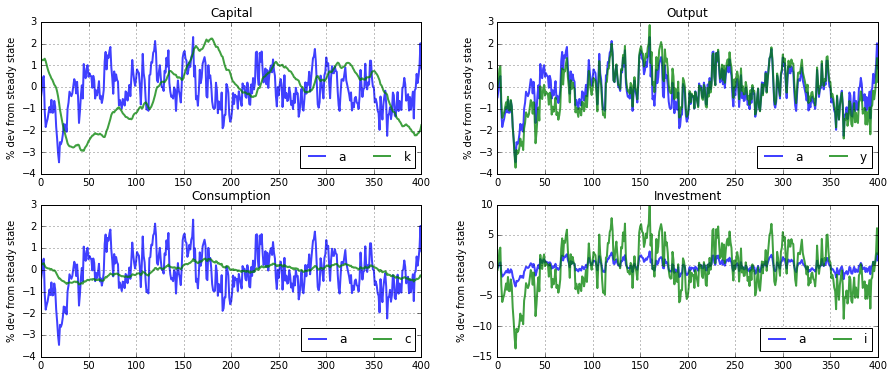

In [13]:
# # Create figure.
# fig = plt.figure(figsize=(15,6))

# # Create axis.
# ax = fig.add_subplot(1,1,1)

# # Plot endogenous variables.
# (rbc_model.simulated[['a','k','y','c','i']]*100).plot(ax=ax,lw=2,alpha=0.75)

# # Set Y-axis label.
# ax.set_label('% dev from ss')

# # Add legend outside plot. 
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # Add a grid.
# ax.grid()

# Create figure.
fig = plt.figure(figsize=(15,6))

# Create four axis variables
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

# Create an axis equal to the size of the figure. 
ax0 = fig.add_subplot(1,1,1)
# Turn off the axis so that the underlying axes are visible.
ax0.set_frame_on(False)
# Hide the x-axis and y-axis
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

# Plot endogenous variables.
(rbc_model.simulated[['a','k']]*100).plot(lw=2, alpha=0.75, grid=True, ax=ax1).legend(loc='lower right',ncol=2)
(rbc_model.simulated[['a','y']]*100).plot(lw=2, alpha=0.75, grid=True, ax=ax2).legend(loc='lower right',ncol=2)
(rbc_model.simulated[['a','c']]*100).plot(lw=2, alpha=0.75, grid=True, ax=ax3).legend(loc='lower right',ncol=2)
(rbc_model.simulated[['a','i']]*100).plot(lw=2, alpha=0.75, grid=True, ax=ax4).legend(loc='lower right',ncol=2)

# Set title
ax1.set_title('Capital')
ax2.set_title('Output') 
ax3.set_title('Consumption')
ax4.set_title('Investment')

# Set ylabel
ax1.set_ylabel('% dev from steady state')
ax2.set_ylabel('% dev from steady state')
ax3.set_ylabel('% dev from steady state')
ax4.set_ylabel('% dev from steady state')

In [14]:
# Print the standard deviations (times 100) of output, consumption, and investment in the simulated data
print(rbc_model.simulated[['y','c','i']].std()*100)

# Print the correlations of output, consumption, and investment in the simulated data
print(rbc_model.simulated[['y','c','i']].corr())

y    1.037653
c    0.277310
i    3.651613
dtype: float64
          y         c         i
y  1.000000  0.674613  0.985647
c  0.674613  1.000000  0.540311
i  0.985647  0.540311  1.000000
